The dataset has limited information including store names, having promotion or not and holiday or not holiday for sales. In this project, the useful date-related info will be extracted from the "date column" and will be added to the dataset to make a reliable dataset for time series sales prediction.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/TimeSeries/Retail_TimeSeries_2/store_sales.csv'

import pandas as pd

# Load CSV file into a DataFrame
data = pd.read_csv(file_path)

# Check the first few rows
data.head()

Mounted at /content/drive


,date,store,sales,promo,holiday
0,2022-01-01,1,184.78,0,0
1,2022-01-02,1,192.62,0,0
2,2022-01-03,1,212.68,0,0
3,2022-01-04,1,249.58,1,0
4,2022-01-05,1,223.50,0,0


In [ ]:
len(data)

7300

In [ ]:
# Select Store 1
store_id = 1

df = data[
    (data['store'] == store_id)
].copy()

## Sort Data based on the Date

In [ ]:
# Parse date
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

# Set date as index and sort
df = df.set_index('date').sort_index()

## Extract Necessary Dtae-Related Information for Building LSTM Model and Modify the Dataet

In [ ]:
# Basic date parts
df['day_of_week'] = df.index.dayofweek        # 0=Mon, 6=Sun
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['month'] = df.index.month

# Weekend flag
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
import numpy as np

# Day of week (7)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Day of month (31)
df['dom_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['dom_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

# Month (12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Week of year (52)
df['woy_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['woy_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

In [ ]:
# Yesterday's sales
df['sales_lag_1'] = df['sales'].shift(1)

# Same weekday last week
df['sales_lag_7'] = df['sales'].shift(7)

In [ ]:
df.head()

,store,sales,promo,holiday,day_of_week,day_of_month,week_of_year,month,is_weekend,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos,woy_sin,woy_cos,sales_lag_1,sales_lag_7
date,,,,,,,,,,,,,,,,,,,
2022-01-01,1,184.78,0,0,5,1,52,1,1,-0.974928,-0.222521,0.201299,0.979530,0.5,0.866025,6.432491e-16,1.000000,NaN,NaN
2022-01-02,1,192.62,0,0,6,2,52,1,1,-0.781831,0.623490,0.394356,0.918958,0.5,0.866025,6.432491e-16,1.000000,184.78,NaN
2022-01-03,1,212.68,0,0,0,3,1,1,0,0.000000,1.000000,0.571268,0.820763,0.5,0.866025,1.205367e-01,0.992709,192.62,NaN
2022-01-04,1,249.58,1,0,1,4,1,1,0,0.781831,0.623490,0.724793,0.688967,0.5,0.866025,1.205367e-01,0.992709,212.68,NaN
2022-01-05,1,223.50,0,0,2,5,1,1,0,0.974928,-0.222521,0.848644,0.528964,0.5,0.866025,1.205367e-01,0.992709,249.58,NaN


In [ ]:
# Handle missing values from lagging
# Lag features introduce NaNs at the beginning.

df = df.dropna()

In [ ]:
# drop columns which can cause misunderstanding for LSTM model
df = df.drop(
    columns=[
        'day_of_week',
        'day_of_month',
        'month',
        'week_of_year'
    ]
)

In [ ]:
df.head()

,store,sales,promo,holiday,is_weekend,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos,woy_sin,woy_cos,sales_lag_1,sales_lag_7
date,,,,,,,,,,,,,,,
2022-01-08,1,213.47,1,0,1,-0.974928,-0.222521,0.998717,-0.050649,0.5,0.866025,0.120537,0.992709,200.43,184.78
2022-01-09,1,222.44,1,0,1,-0.781831,0.623490,0.968077,-0.250653,0.5,0.866025,0.120537,0.992709,213.47,192.62
2022-01-10,1,203.10,0,0,0,0.000000,1.000000,0.897805,-0.440394,0.5,0.866025,0.239316,0.970942,222.44,212.68
2022-01-11,1,218.78,0,0,0,0.781831,0.623490,0.790776,-0.612106,0.5,0.866025,0.239316,0.970942,203.10,249.58
2022-01-12,1,266.23,0,1,0,0.974928,-0.222521,0.651372,-0.758758,0.5,0.866025,0.239316,0.970942,218.78,223.50


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2022-01-08 to 2023-12-31
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store        723 non-null    int64  
 1   sales        723 non-null    float64
 2   promo        723 non-null    int64  
 3   holiday      723 non-null    int64  
 4   is_weekend   723 non-null    int64  
 5   dow_sin      723 non-null    float64
 6   dow_cos      723 non-null    float64
 7   dom_sin      723 non-null    float64
 8   dom_cos      723 non-null    float64
 9   month_sin    723 non-null    float64
 10  month_cos    723 non-null    float64
 11  woy_sin      723 non-null    float64
 12  woy_cos      723 non-null    float64
 13  sales_lag_1  723 non-null    float64
 14  sales_lag_7  723 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 90.4 KB
None


## Visualize the Sales Trend

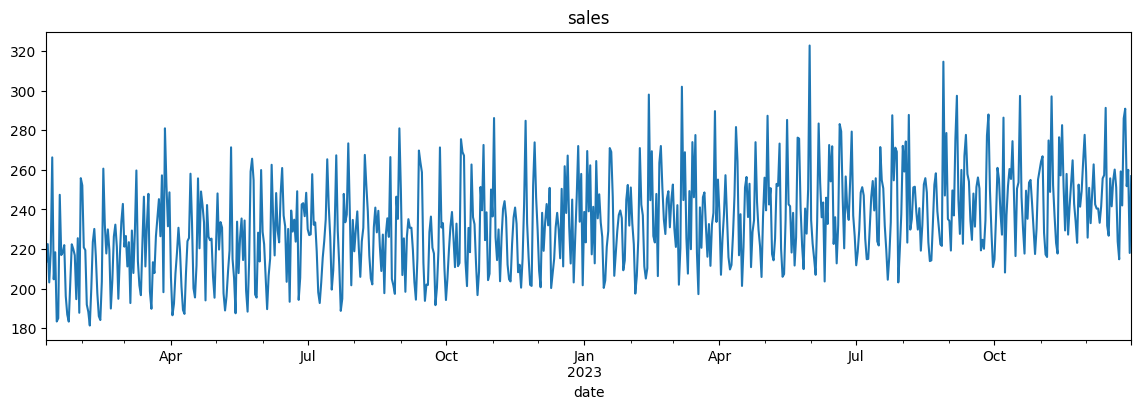

In [ ]:
import matplotlib.pyplot as plt

df['sales'].plot(figsize=(14,4), title='sales')
plt.show()

In [ ]:
# check missing
print("Any nulls?", df.isnull().any().any())

Any nulls? False


## Train, Validation and Test Data Preparation

In [ ]:
# Total number of observations
n = len(df)

# Indices for splits
train_end = int(n * 0.80)
val_end = int(n * 0.90)

# Split the data
df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

# Sanity checks
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

Train: (578, 15)
Validation: (72, 15)
Test: (73, 15)


In [ ]:
# Target variable
target = 'sales'

# Categorical features
categorical_features = [
    'store',
    'holiday',
    'promo',
    'is_weekend'
]


# Numerical features
numerical_features = [

    # Cyclical encodings
    'dow_sin',
    'dow_cos',
    'dom_sin',
    'dom_cos',
    'month_sin',
    'month_cos',
    'woy_sin',
    'woy_cos',

    # Lagged sales
    'sales_lag_1',
    'sales_lag_7'
]

In [ ]:
# Split features and target
X_train = df_train[categorical_features + numerical_features]
y_train = df_train[target]

X_val = df_val[categorical_features + numerical_features]
y_val = df_val[target]

X_test = df_test[categorical_features + numerical_features]
y_test = df_test[target]

## Scaling and One Hot Encoding the Data

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Feature preprocessor (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Fit ONLY on training features
X_train_processed = preprocessor.fit_transform(X_train)

# Transform validation and test features
X_val_processed  = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print("X train shape:", X_train_processed.shape)
print("X val shape:", X_val_processed.shape)
print("X test shape:", X_test_processed.shape)

X train shape: (578, 17)
X val shape: (72, 17)
X test shape: (73, 17)


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Target scaler
y_scaler = StandardScaler()

# Fit ONLY on training target
y_train_processed = y_scaler.fit_transform(
    y_train.values.reshape(-1, 1)
)

# Transform validation and test target
y_val_processed = y_scaler.transform(
    y_val.values.reshape(-1, 1)
)

y_test_processed = y_scaler.transform(
    y_test.values.reshape(-1, 1)
)

print("y train shape:", y_train_processed.shape)
print("y val shape:", y_val_processed.shape)
print("y test shape:", y_test_processed.shape)

y train shape: (578, 1)
y val shape: (72, 1)
y test shape: (73, 1)


## Creating the Sliding Windows for Navigating the Time Series Model

In [ ]:
import numpy as np

def create_sliding_windows(X, y, window_size):
    X_windows = []
    y_windows = []

    for i in range(len(X) - window_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size, 0])

    return np.array(X_windows), np.array(y_windows)


window_size = 30

X_train_win, y_train_win = create_sliding_windows(
    X_train_processed, y_train_processed, window_size
)

X_val_win, y_val_win = create_sliding_windows(
    X_val_processed, y_val_processed, window_size
)

X_test_win, y_test_win = create_sliding_windows(
    X_test_processed, y_test_processed, window_size
)

print("Train windows:", X_train_win.shape, y_train_win.shape)
print("Val windows:", X_val_win.shape, y_val_win.shape)
print("Test windows:", X_test_win.shape, y_test_win.shape)

Train windows: (548, 30, 17) (548,)
Val windows: (42, 30, 17) (42,)
Test windows: (43, 30, 17) (43,)


## Model Build Up

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.4239 - mae: 0.7978 - val_loss: 0.4973 - val_mae: 0.8898
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3859 - mae: 0.7532 - val_loss: 0.4268 - val_mae: 0.8202
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3742 - mae: 0.7396 - val_loss: 0.4600 - val_mae: 0.8127
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3288 - mae: 0.6729 - val_loss: 0.3261 - val_mae: 0.6349
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2706 - mae: 0.6126 - val_loss: 0.2974 - val_mae: 0.5813
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2672 - mae: 0.6309 - val_loss: 0.3569 - val_mae: 0.6549
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2442 - mae: 0.5782 - val_loss: 0.3882 - val_mae: 0.7145
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2391 - mae: 0.5730 - val_loss: 0.3160 - val_mae: 0.5940
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.24

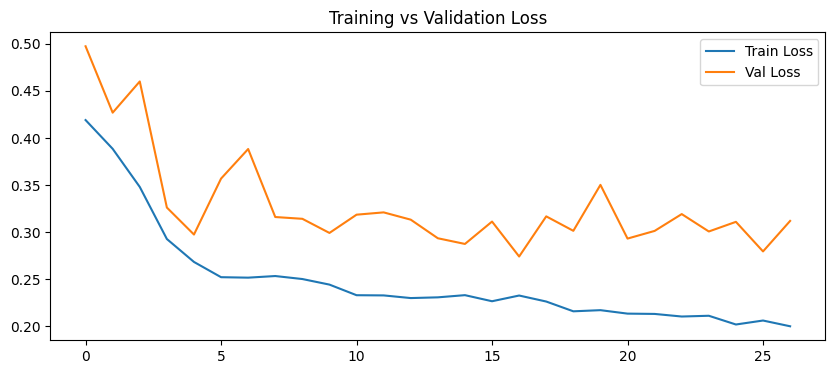

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def build_lstm_model(
    input_shape,
    lstm_units_1=64,
    lstm_units_2=64,
    dense_units=32,
    dropout_rate=0.2,
    learning_rate=0.001
):
    model = Sequential()

    model.add(
        LSTM(
            lstm_units_1,
            return_sequences=True,
            input_shape=input_shape
        )
    )

    model.add(LSTM(lstm_units_2))
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=Huber(delta=1.0),
        #loss='mse',
        metrics=['mae']
    )

    return model



input_shape = (X_train_win.shape[1], X_train_win.shape[2])

model = build_lstm_model(input_shape)
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train_win,
    y_train_win,
    validation_data=(X_val_win, y_val_win),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


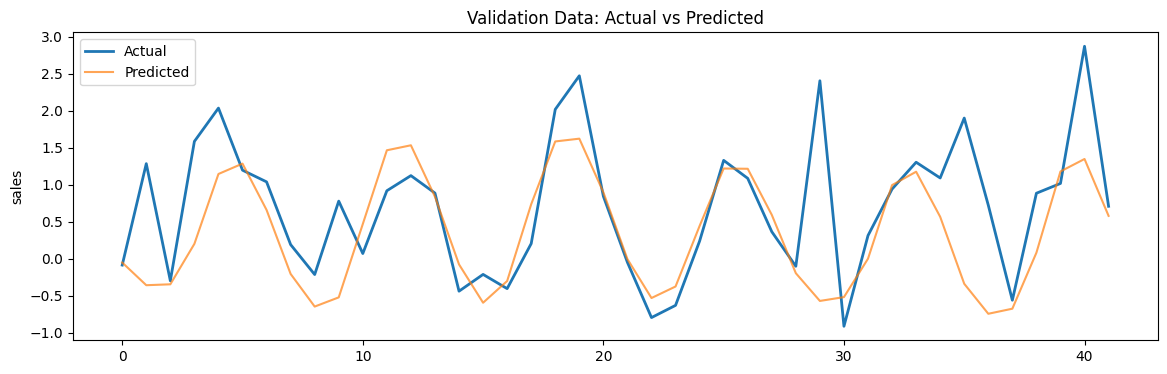

In [ ]:
import numpy as np

# Predict on validation data
y_val_pred = model.predict(X_val_win).flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(y_val_win, label='Actual', linewidth=2)
plt.plot(y_val_pred, label='Predicted', alpha=0.7)
plt.title('Validation Data: Actual vs Predicted')
plt.ylabel('sales')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


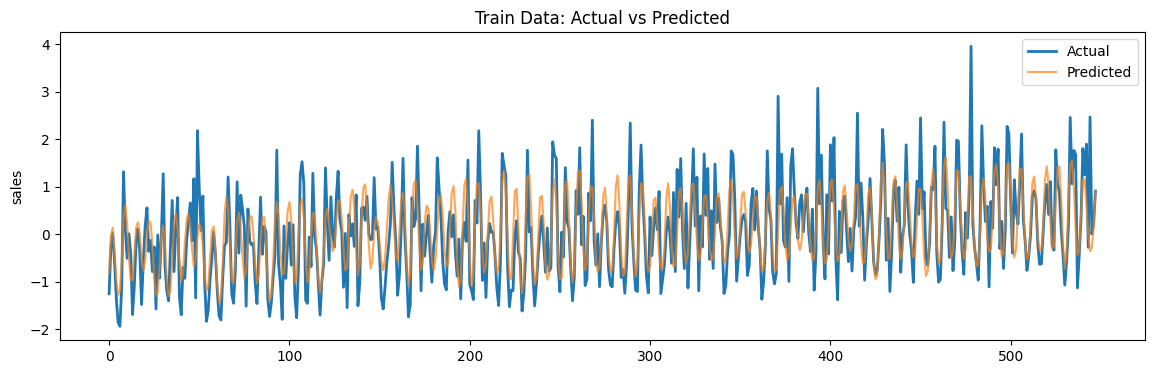

In [ ]:
import numpy as np

# Predict on train data
y_train_pred = model.predict(X_train_win).flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(y_train_win, label='Actual', linewidth=2)
plt.plot(y_train_pred, label='Predicted', alpha=0.7)
plt.title('Train Data: Actual vs Predicted')
plt.ylabel('sales')
plt.legend()
plt.show()

## Feature Importance

Total features: 17
Feature names: ['dow_sin', 'dow_cos', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos', 'woy_sin', 'woy_cos', 'sales_lag_1', 'sales_lag_7', 'store_1', 'holiday_0', 'holiday_1', 'promo_0', 'promo_1', 'is_weekend_0', 'is_weekend_1']
Baseline validation loss: 0.2741
Feature importance:
         feature  importance
1        dow_cos    0.079766
9    sales_lag_7    0.042346
0        dow_sin    0.017769
13       promo_0    0.016051
8    sales_lag_1    0.012622
3        dom_cos    0.008354
16  is_weekend_1    0.003978
6        woy_sin    0.003546
11     holiday_0    0.001785
14       promo_1   -0.001212
7        woy_cos   -0.002132
10       store_1   -0.004266
12     holiday_1   -0.005087
5      month_cos   -0.006541
4      month_sin   -0.007390
15  is_weekend_0   -0.009836
2        dom_sin   -0.012980


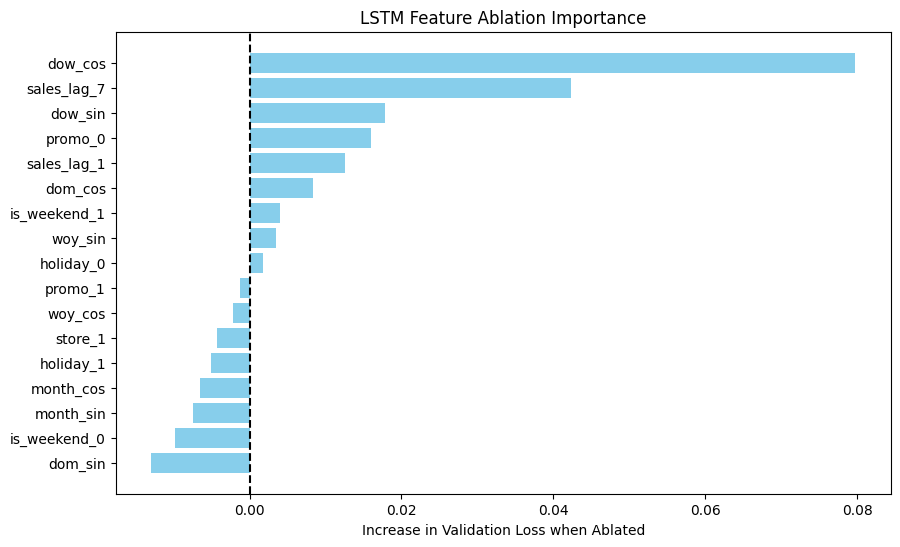

Weak / unimportant features to consider dropping: ['promo_1', 'woy_cos', 'store_1', 'holiday_1', 'month_cos', 'month_sin', 'is_weekend_0', 'dom_sin']


In [ ]:

# -------------------------------
# 1️⃣ Extract feature names from preprocessor
# -------------------------------

# Get numerical feature names (scaled)
num_features = numerical_features.copy()

# Get categorical feature names after one-hot encoding
cat_features_ohe = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine numerical + categorical
feature_names = num_features + cat_features_ohe.tolist()

print("Total features:", len(feature_names))
print("Feature names:", feature_names)

# Sanity check: must match X_train_win shape
assert len(feature_names) == X_train_win.shape[2], "Feature names do not match window features!"

# -------------------------------
# 2️⃣ Feature Ablation Function
# -------------------------------
def ablation_test(model, X, y, feature_names):
    """
    Compute feature importance for LSTM via ablation.
    Sets each feature to 0 across all timesteps and measures increase in validation loss.
    """
    baseline_loss, _ = model.evaluate(X, y, verbose=0)
    print(f"Baseline validation loss: {baseline_loss:.4f}")

    results = []
    for i, feature in enumerate(feature_names):
        X_ablate = X.copy()
        X_ablate[:, :, i] = 0.0  # zero out the feature
        loss, _ = model.evaluate(X_ablate, y, verbose=0)
        importance = loss - baseline_loss
        results.append({'feature': feature, 'importance': importance})

    importance_df = pd.DataFrame(results).sort_values('importance', ascending=False)
    return importance_df

# -------------------------------
# 3️⃣ Run feature ablation on validation set
# -------------------------------
importance_df = ablation_test(model, X_val_win, y_val_win, feature_names)

# -------------------------------
# 4️⃣ Show top features
# -------------------------------
print("Feature importance:")
print(importance_df)

# -------------------------------
# 5️⃣ Plot the feature importance
# -------------------------------
plt.figure(figsize=(10,6))
plt.barh(
    importance_df['feature'],
    importance_df['importance'],
    color='skyblue'
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Increase in Validation Loss when Ablated')
plt.title('LSTM Feature Ablation Importance')
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# 6️⃣ Identify weak features to drop
# -------------------------------
weak_features = importance_df.loc[importance_df['importance'] <= 0, 'feature'].tolist()
print("Weak / unimportant features to consider dropping:", weak_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


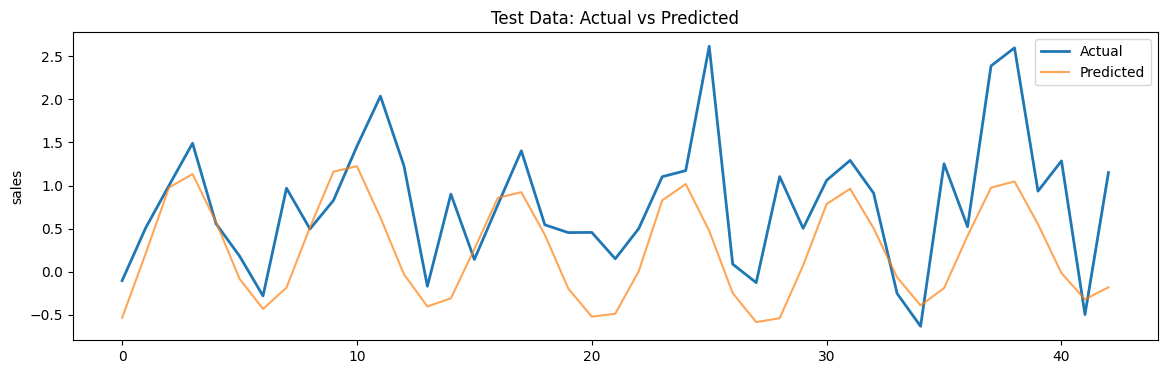

In [ ]:
import numpy as np

# Predict on test data
y_test_pred = model.predict(X_test_win).flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(y_test_win, label='Actual', linewidth=2)
plt.plot(y_test_pred, label='Predicted', alpha=0.7)
plt.title('Test Data: Actual vs Predicted')
plt.ylabel('sales')
plt.legend()
plt.show()